# Synthetic + real EEG
This script takes the synthetic EEG generated by the signal generator scripts and convolves the appropriate channels with the actual EEG data stored in artifact data.

In [1]:
# Import libraries
import os
import numpy as np
import scipy.signal as signal
import scipy.io
import matplotlib.pyplot as plt

# Determine working directory
file_path = os.getcwd()

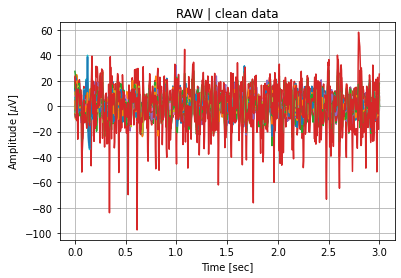

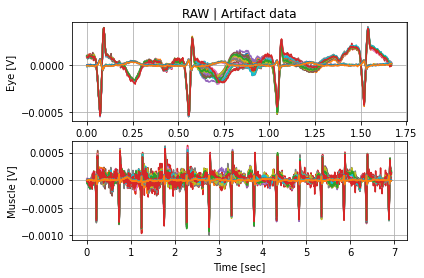

In [4]:
plot_raw = True # Boolean to plot raw data after imported

# Import data
# - Clean data -> Options: S01, S02, S03 
# - Note: Amplitude is in [\muV]
clean = np.load(file_path+'\\BETA dataset\\S01.npz', allow_pickle=True) 

# - Artifact data -> Options: AS02
# - Note: Amplitude is in [V]
artifact = np.load(file_path+'\\Temple artifact data\\AS02.npz', allow_pickle=True) 

# Check that sampling rates are the same
if clean['srate'] == artifact['srate']:
    srate = clean['srate']
else:
    print('Warning sampling rates of clean and artifact data are not the same')
    print(f'Clean =',clean['srate'])
    print(f'Artifact = '+artifact['srate'])

# Print raw data if desired
if plot_raw:
    block_clean = 1   # Select block to plot -> 0=10Hz, 1=12Hz, 2=15Hz
    plot_clean = clean['eeg'][:,:,block_clean]
    time_eeg = np.linspace(0, len(plot_clean)/clean['srate'], len(plot_clean))

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title('RAW | clean data')
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude [$\mu$V]')
    ax.plot(time_eeg, plot_clean)
    # ax.plot(time_eeg, clean_eeg[:,ic_chans,2])
    ax.grid()
    plt.show()

    bloc_art = 3;   # Select block to plot. Eye and Muscle artifacts might have diff number of blocks
    plot_eye = artifact['eye_eeg'][bloc_art]
    plot_mus = artifact['mus_eeg'][bloc_art]
    time_eye = np.linspace(0, len(plot_eye)/artifact['srate'], len(plot_eye))
    time_mus = np.linspace(0, len(plot_mus)/artifact['srate'], len(plot_mus))

    [fig, axs] = plt.subplots(2,1)
    axs[0].set_title('RAW | Artifact data')
    axs[0].set_ylabel('Eye [V]')
    axs[0].grid()
    axs[0].plot(time_eye, plot_eye)
    axs[1].set_ylabel('Muscle [V]')
    axs[1].set_xlabel('Time [sec]')
    axs[1].grid()
    axs[1].plot(time_mus, plot_mus)
    plt.show()

## Combine data
This section combines the data from the clean trials with the artifact data. A few considerations:
- The clean data amplitude is in [$\mu$ V] while the artifact data is in [V].
- The clean data has **64** EEG channels while the artifact data has **15** EEG channels.

First, make sure that you are using the same channels in both datasets

In [13]:
# Find sorted intersection of channels
# - Setup channels to find intersection
artifact_chans = artifact['chans'][0:19] # Order of selected channels to use [n=19]
clean_chans = clean['chans'][:,3] # Order of clean channels [n=64]  

# - Find channel intersection
# -- chans = combined channels
# -- ic_chans = Indexes of clean channels
# -- ia_chans = Indexes of artifact channels
[chans, ic_chans, ia_chans] = np.intersect1d(clean_chans, artifact_chans, return_indices=True)  
print(f'Channels kept: {chans}')

Channels kept: ['C3' 'C4' 'CZ' 'F3' 'F4' 'F7' 'F8' 'FP1' 'FP2' 'FZ' 'O1' 'O2' 'P3' 'P4'
 'PZ']


Second, convolve the channels in the appropriate order

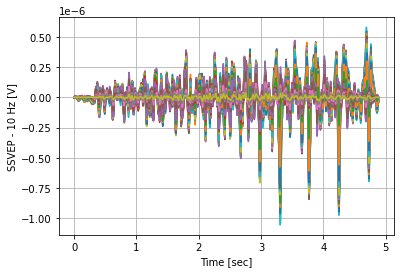

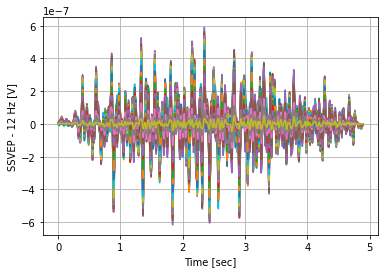

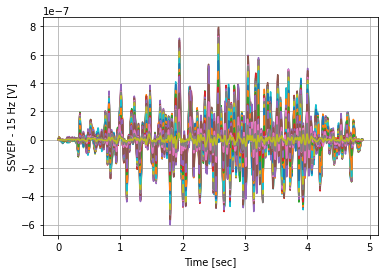

In [39]:
plot_conv = True   # Boolean to plot the convolved data

# Scale clean EEG data from [\muV] to [V]
s_factor = 1e-6  # Scaling factor to have all data in [V]
clean_eeg = clean['eeg'] * s_factor # Clean EEG signal [V]

# Convolve clean EEG with artifact EEG
select_artifact = 'eye'     # Select type of artifact -> Options = 'eye', or 'mus'
select_artifact_block = 2   # Select block of artifact

# For each ssvep stimulus 
# Note: Only the intersecting channels are selected
conv_data = np.empty(len(clean['ssvep']), dtype='object')
time_conv = np.empty(len(clean['ssvep']), dtype='object')

for [i,ssvep] in np.ndenumerate(clean['ssvep']):
    temp_data = np.squeeze(clean_eeg[:,ic_chans,i])
    
    if select_artifact == 'eye':
        temp_artifact = artifact['eye_eeg'][select_artifact_block][:,ia_chans]
    elif select_artifact == 'mus':
        temp_artifact = artifact['mus_eeg'][select_artifact_block][:,ia_chans]
    else:
        print('Warning, wrong type of artifact selected')

    # Convolve data
    # conv_data[i] = signal.convolve(temp_data, temp_artifact, mode='same', method='fft')
    conv_data[i] = signal.convolve(temp_data, temp_artifact, mode='full')
    time_conv[i] = np.linspace(0, len(conv_data[i])/srate, len(conv_data[i]))

    if plot_conv:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel(f'SSVEP - {ssvep} Hz [V]')
        ax.grid()
        plt.plot(time_conv[i], conv_data[i])
        plt.show()

In [37]:
b = conv_data[2]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [15]:
a = artifact['mus_eeg'][41]
print(ia_chans)

[ 4  5 17  2  3 10 11  0  1 16  8  9  6  7 18]


## Plot PSD
This section plots the power spectral density (PSD) of the convoluted (EEG + artifact) data.

In [16]:
for i in range(3):
    if i == 0: print('Clean data')
    print(f'Range = {np.max(clean_eeg[:,:,i])- np.min(clean_eeg[:,:,i]) * 1e6} [\muV]')


print('\nArtifact data')
ma = np.max(artifact[f'{select_artifact}_eeg'][select_artifact_block][:,ia_chans])
mi = np.min(artifact[f'{select_artifact}_eeg'][select_artifact_block][:,ia_chans])
print(f'Range = {(ma-mi)*1e6}')

Clean data
Range = 88.02581263040825 [\muV]
Range = 97.44024609974664 [\muV]
Range = 64.3779517261179 [\muV]

Artifact data
Range = 1046.2142877005542


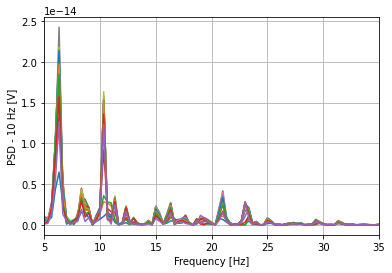

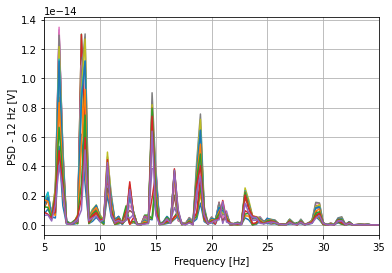

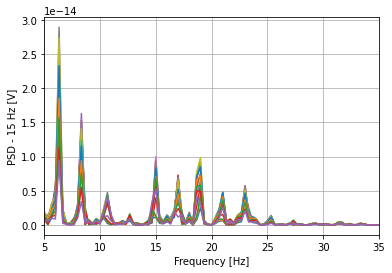

In [17]:
plot_psd = True # Boolean to plot the PSD of the data

if plot_psd:
    for [i,ssvep] in np.ndenumerate(clean['ssvep']):
        # data = np.squeeze(clean_eeg[:,:,i]) # Enable for clean data
        data = conv_data[i]

        win = np.ones(len(data))
        [f, pxx] = signal.welch(data, fs=srate, window=win, axis=0)

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel(f'PSD - {ssvep} Hz [V]')
        ax.set_xlim(5, 35)
        ax.grid()
        plt.plot(f, pxx)
        plt.show()

        

## Save data
Save clean and convolved data to the same file, include the channels and sampling rate [Hz]

In [18]:
save_data = False   # Boolean to save convolved data
save_matlab = True  # Boolean to save Matlab formatted data

if save_data:   
    np.savez(f'conv_{select_artifact}_data', clean=clean_eeg, conv=conv_data, \
        chans=chans, clean_chans=clean_chans, srate=srate)

if save_matlab:
    data_dict = {'clean':clean_eeg, 'conv':conv_data, 'chans':chans, 'clean_chans':clean_chans, \
        'srate':srate}
    scipy.io.savemat(f'conv_{select_artifact}_data.mat', data_dict)